# Analysis of a bias-free network

A bias-free network operates on its input by applying an adaptive linear transform (adaptive, because the transform is dependent on the input image). In this notebook, we analyze the properties of this transform using singular value decomposition.


In [1]:
!pip install ipython==7.9.0

In [2]:
!pip install multiprocess

In [3]:
!pip install tqdm

In [4]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as patches
import os
import torch
from skimage import io
from skimage.measure.simple_metrics import compare_psnr, compare_mse
import sys  
from utils import *
import time 

In [5]:
# %matplotlib notebook

In [6]:

%load_ext autoreload
%autoreload 2

In [7]:
# Paths for data, pretrained models, and precomputed performance measures
pretrained_base = './pretrained/'
precomputed_base = './precomputed/'
data_base = 'data/'

# Datasets available in the data folder
train_folder_path = os.path.join(data_base, 'Train400/')
test_folder_path = os.path.join(data_base, 'Test/Set68/')
set12_path = os.path.join(data_base, 'Test/Set12/')
kodak_path = os.path.join(data_base, 'Test/Kodak23/') 

### Choose a model 

Note: we provide four pre-trained models. You can train and analyze any other model (and its bias-free counterpart) using the train script provided in the repository. 

In [8]:
# Choose a model (pre-trained options: 'dncnn', 'unet', 'rcnn', 'sdensenet')
model = 'dncnn' 

# Select the range of noise levels (stdev, relative to intensities in range [0,255]) 
# used during training (options are 0-10, 0-30, 0-55, 0-100).
l = 0   # lower bound of training range 
h = 100 # upper bound of training range

BF_CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(l)+'-'+str(h)+'.pt'))

### Choose a clean image


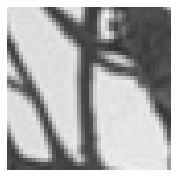

In [9]:
# choose a clean image (figure 4 in paper uses image_num=15)
image_num =15# 24
clean_im = single_image_loader(test_folder_path, image_num)

# Crop out a 40x40 patch (optional, helps for visibility.  Same values used for Figure 4 in paper).
clean_im = clean_im[100:140, 100:140]#
dim1, dim2 = clean_im.shape
f , axs = plt.subplots(1,1 , figsize=(3,3))    
axs.imshow(clean_im, 'gray', vmin=0, vmax = 1)
axs.axis('off');


(array([153., 322.,  90.,  57.,  54.,  64.,  51.,  54., 213., 542.]),
 array([0.18823529, 0.26392157, 0.33960784, 0.41529412, 0.49098039,
        0.56666667, 0.64235294, 0.71803922, 0.79372549, 0.86941176,
        0.94509804]),
 <BarContainer object of 10 artists>)

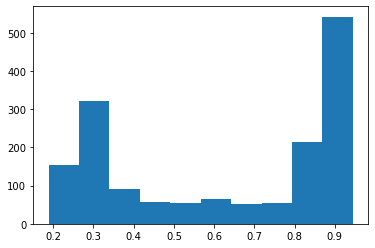

In [10]:
plt.hist(clean_im.flatten())

# Resize

In [11]:
import scipy.ndimage

In [12]:
clean_im_rs=scipy.ndimage.zoom(clean_im,5)

In [13]:
np.shape(clean_im)

(40, 40)

In [14]:

residual_imgs = []

In [15]:

noisy_im = add_noise2(clean_im.reshape(1,dim1,dim2), 135, 'S')[0][0] 

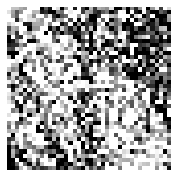

In [16]:
f , axs = plt.subplots(1,1 , figsize=(3,3))    
axs.imshow(noisy_im, 'gray', vmin=0, vmax = 1)
axs.axis('off');

In [17]:
np.shape(noisy_im)

(40, 40)

In [18]:
# start_time_total = time.time()
# scaling = .00001
# A = calc_jacobian(scaling*noisy_im,BF_CNN)
# print("---- Jacobian computation time --- %s seconds ---" % (time.time() - start_time_total))

# Hessian via multiprocessing

In [19]:
from multiprocess import Pool

In [20]:
from multiprocess import set_start_method
try:
    set_start_method('spawn')
except RuntimeError:
    pass

In [21]:
from hessian_util import *

In [22]:
import torch.multiprocessing as mp

In [23]:
from torch.multiprocessing import set_start_method
try:
    set_start_method('spawn')
except RuntimeError:
    pass

In [24]:
from functools import partial

In [25]:

from itertools import product

In [26]:
%%time
hess_all = []
if __name__ == '__main__':
#     for ci in range(0,40,2):
    for ci in range(16,26,2):

        xc = 80
        
        jarr = np.arange(xc)
        cl = list(ci*np.ones([40],dtype=int))
        cl.extend(list((ci+1)*np.ones([40],dtype=int)))

        coord_gpu = [(ii*8//xc,np.mod(ii,40),cl[ii]) for ii in jarr]
#         print(coord_gpu)
        
        # im = .00001*noisy_im
        im = noisy_im
        # model = BF_CNN
    #     im=torch.tensor(im.astype('float32'),requires_grad=True).unsqueeze(0).unsqueeze(0).cuda()

        BF_CNN.share_memory()
    #     imc.share_memory()
        #p.daemon = True
        # jacob=[]
        # p = mp.Process(target=calc_hessian_mp,args=(imc.detach(),jacob,))
        # out2=p.start()
        # out=p.join()
        hess_mp = []
        func = partial(calc_hessian_mpf, im)
    #     jarr = np.arange(40)
        nreps = len(coord_gpu)
    #     coord_gpu = [(0, 15), (0, 16), (1,17), (1,18)]
#         print(nreps)
        with Pool(processes=nreps) as pool:
    #         hess_mp = pool.map(calc_hessian_mpf, imc.detach())
    #         hess_mp = pool.starmap(func, product([0],jarr))
            hess_mp = pool.starmap(func, coord_gpu)
    #         hess_mp = pool.apply_async(func, [15,16,17,18,19,20,21,22])
        print(ci,' done')
        hess_all.extend(hess_mp)

16  done
18  done
20  done
22  done
24  done
CPU times: user 2.3 s, sys: 14.7 s, total: 17 s
Wall time: 4min 48s


In [27]:
np.shape(im)

(40, 40)

In [26]:
%%time
hess_all = []
if __name__ == '__main__':
    for ci in range(0,40,2):

        xc = 80
        
        jarr = np.arange(xc)
        cl = list(ci*np.ones([40],dtype=int))
        cl.extend(list((ci+1)*np.ones([40],dtype=int)))

        coord_gpu = [(ii*8//xc,np.mod(ii,40),cl[ii]) for ii in jarr]
#         print(coord_gpu)
        
        # im = .00001*noisy_im
        im = noisy_im
        # model = BF_CNN
    #     im=torch.tensor(im.astype('float32'),requires_grad=True).unsqueeze(0).unsqueeze(0).cuda()

        BF_CNN.share_memory()
    #     imc.share_memory()
        #p.daemon = True
        # jacob=[]
        # p = mp.Process(target=calc_hessian_mp,args=(imc.detach(),jacob,))
        # out2=p.start()
        # out=p.join()
        hess_mp = []
        func = partial(calc_hessian_mpf, im)
    #     jarr = np.arange(40)
        nreps = len(coord_gpu)
    #     coord_gpu = [(0, 15), (0, 16), (1,17), (1,18)]
#         print(nreps)
        with Pool(processes=nreps) as pool:
    #         hess_mp = pool.map(calc_hessian_mpf, imc.detach())
    #         hess_mp = pool.starmap(func, product([0],jarr))
            hess_mp = pool.starmap(func, coord_gpu)
    #         hess_mp = pool.apply_async(func, [15,16,17,18,19,20,21,22])
        print(ci,' done')
        hess_all.extend(hess_mp)

0  done
2  done
4  done
6  done
8  done
10  done
12  done
14  done
16  done
18  done
20  done
22  done
24  done
26  done
28  done
30  done
32  done
34  done
36  done
38  done
CPU times: user 45.3 s, sys: 3min 30s, total: 4min 15s
Wall time: 41min 44s


In [35]:
def curvature_nd(ygrad,yhess):    

    sx = np.zeros([len(ygrad),len(ygrad)+1])
    sxeye = np.eye(len(ygrad))

    sx[:len(ygrad),:len(ygrad)]=sxeye
    sx[:,len(ygrad)]=ygrad

    FF = np.matmul(sx,sx.T)
    
    V =  np.eye(len(ygrad))
    xv = ygrad
    sn0 = np.matmul(V,xv)
    sn = np.zeros(np.shape(sn0)[0]+1)
    sn[:-1]=sn0
    sn[-1]=-1.
    C = sn/np.linalg.norm(sn)
    
#     SF = np.zeros_like(FF)
    
#     for ii in range(len(ygrad)):
#         for jj in range(len(ygrad)):
#             zvec = np.zeros([len(ygrad)+1,1])
#             zvec[-1]=yhess[ii][jj]
#             SF[ii,jj]=np.matmul(zvec[:,0],C)           

#     yhessz = np.zeros([1600,1600])
#     yhessz[0,:]=np.array(yhess)
    SF=np.reshape(np.array(yhess).flatten()*C[-1],[1600,1600])
    if 1:#np.max(np.isnan(SF).flatten()) or np.max(np.isnan(FF).flatten()):
        SO = np.linalg.solve(FF,SF)#,rcond=-1)#[0]
        
    return SO

In [28]:
hess_arr = []
for ii in range(1600):
    hess_arr.extend(hess_all[ii][0])

In [29]:
hess_arr = np.array(hess_arr)

In [30]:
np.shape(hess_arr)

(1600, 1600)

In [31]:
hess_cv = hess_arr

In [32]:
kd,KM=np.linalg.eig(hess_cv)

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


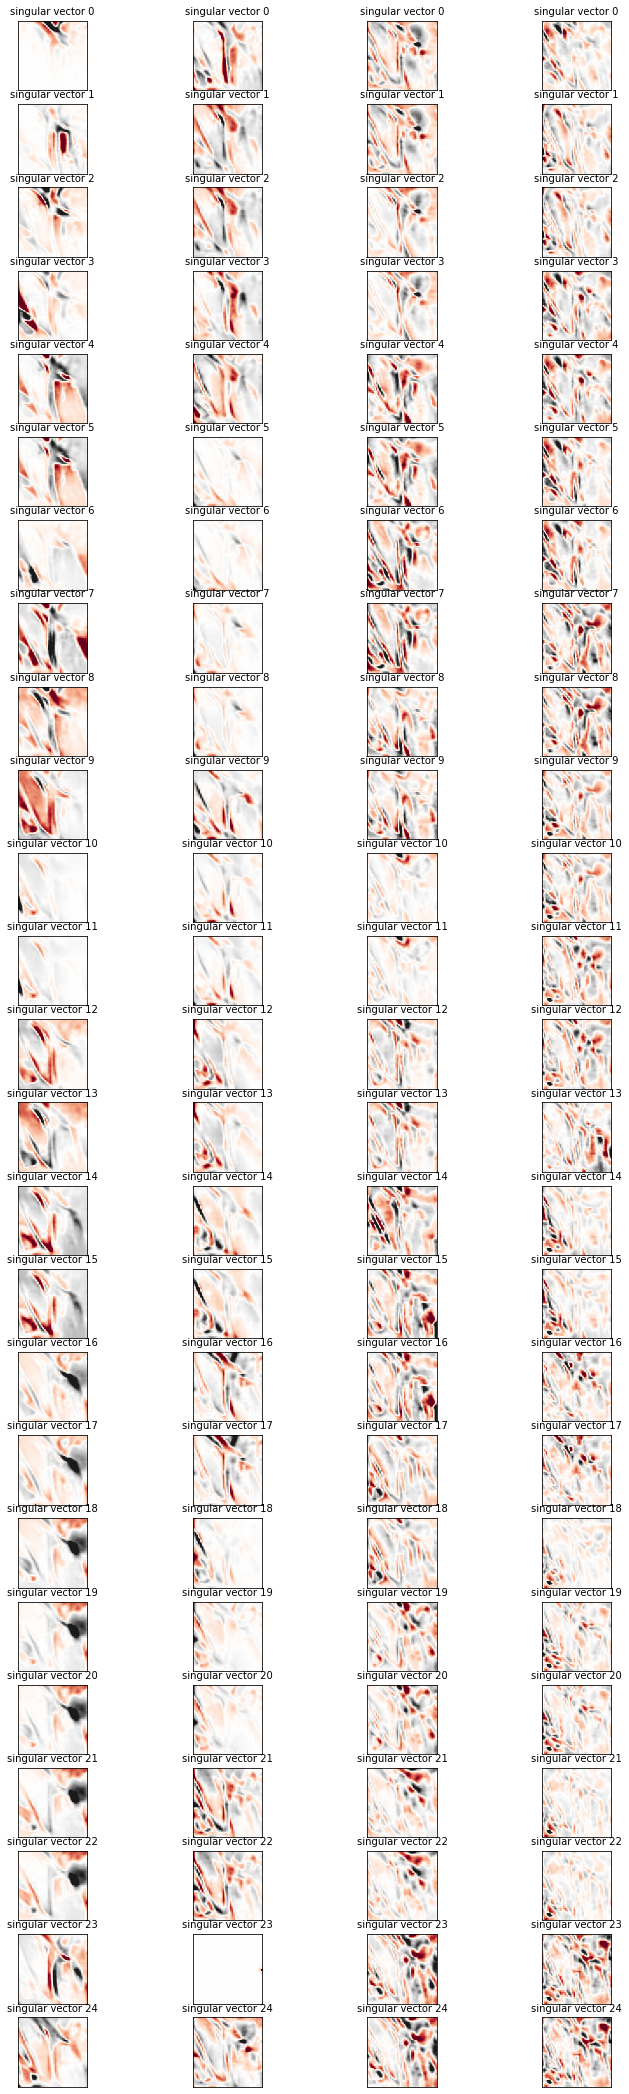

In [33]:
kd,KM=np.linalg.eig(hess_cv)
# Show some example singular vectors with large singular values
sing_vect_n = np.add(0,[0,2,4,6,10,12,14,16,20,22,24,26]) # indices of the singular vectors for visualization 

mm=25
sing_vect_n = np.arange(4*mm)
# sing_vect_n = list(-1*np.arange(10))
N = 1600 # dimensionality of the space
# Bnp =SO#[:,np.argsort(np.linalg.norm(SO,axis=1))]#B.cpu().numpy()
# kd,KM=np.linalg.eig(SO);
Bnp=np.real(KM)
f , axs = plt.subplots(len(sing_vect_n)//4, 4,figsize=(12,38))    
plt.subplots_adjust()
for j in range(4):
    for i in range(len(sing_vect_n)//4):
        u = Bnp[:,sing_vect_n[(len(sing_vect_n)//4)*j+i]]
        
        limit =  max(np.abs(np.min( u)), np.abs(np.max(u)))
        v = 0.#V[sing_vect_n[i],:]
        axs[i,j].imshow(u.reshape(dim1,dim2), 'RdGy', vmin=-limit/2, vmax = limit/2)
        axs[i,j].set_title('singular vector '+str(sing_vect_n[i]), fontsize = 10, fontname= 'Times New Roman')
        axs[i,j].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
#         axs[i,j].set_xlabel(r'$v^Tu$ =  '+str(np.round( np.dot(u,v) ,2))+ '\n $s =$ '+str(np.round(KM[sing_vect_n[i]],1)),
#                           fontsize = 10, fontname= 'Times New Roman');

In [32]:
np.shape(hess_all[0][1])

(1, 1600)

In [36]:
SOall = []
for xi in range(1600):
    
    SO = curvature_nd(hess_all[xi][0][0],hess_all[xi][1])
    SOall.extend(np.subtract(SO,np.mean(SO,axis=0)).T)
    
    
    if np.mod(xi,100)==0:
        print(xi)
#             else:

0
100
200
300


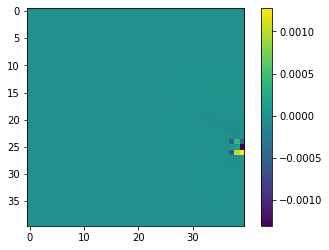

In [37]:
plt.imshow(np.reshape(np.mean(SO,axis=0),[40,40]))
plt.colorbar()

In [38]:
# hess_arr = []
# for ii in range(1600):
#     hess_arr.extend(hess_all[ii][1])

In [39]:
hess_arr = np.array(SOall)

In [40]:
hess_arr = np.subtract(hess_arr,np.mean(hess_arr,axis=0))

In [41]:
hess_cv = np.matmul(hess_arr.T,hess_arr)

In [42]:
np.shape(hess_cv)

(1600, 1600)

In [43]:
kd2,KM2=np.linalg.eig(hess_cv.T)

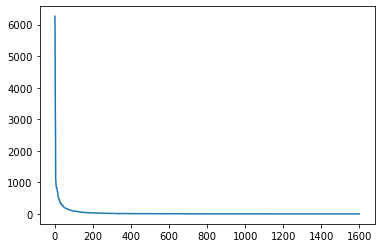

In [49]:
plt.plot(kd2)

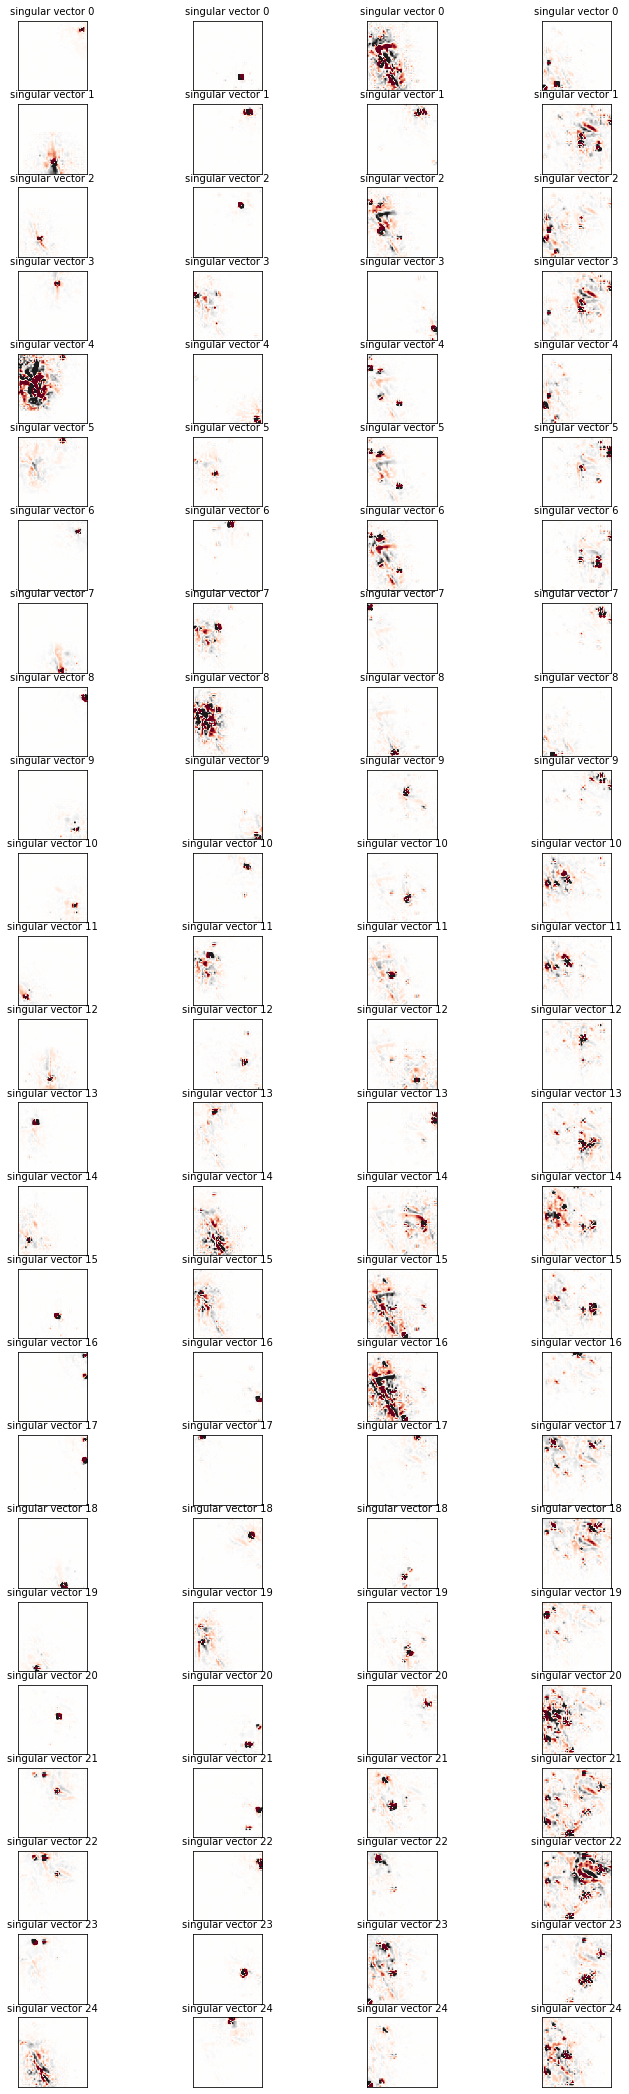

In [98]:
# Show some example singular vectors with large singular values
# sing_vect_n = np.add(0,[0,2,4,6,10,12,14,16,20,22,24,26]) # indices of the singular vectors for visualization 

mm=25
sing_vect_n = 0+np.arange(4*mm)
# sing_vect_n = list(-1*np.arange(10))
N = 1600 # dimensionality of the space
# Bnp =SO#[:,np.argsort(np.linalg.norm(SO,axis=1))]#B.cpu().numpy()
# kd,KM=np.linalg.eig(SO);
Bnp=KM2
f , axs = plt.subplots(len(sing_vect_n)//4, 4,figsize=(12,38))    
plt.subplots_adjust()
for j in range(4):
    for i in range(len(sing_vect_n)//4):
        u = Bnp[:,sing_vect_n[(len(sing_vect_n)//4)*j+i]]
        
        limit =  .2*max(np.abs(np.min( u)), np.abs(np.max(u)))
        v = 0.#V[sing_vect_n[i],:]
        axs[i,j].imshow(u.reshape(dim1,dim2), 'RdGy', vmin=-limit/2, vmax = limit/2)
        axs[i,j].set_title('singular vector '+str(sing_vect_n[i]), fontsize = 10, fontname= 'Times New Roman')
        axs[i,j].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
#         axs[i,j].set_xlabel(r'$v^Tu$ =  '+str(np.round( np.dot(u,v) ,2))+ '\n $s =$ '+str(np.round(KM[sing_vect_n[i]],1)),
#                           fontsize = 10, fontname= 'Times New Roman');